In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

In [3]:
print(os.listdir('/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset'))

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


In [4]:
MildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented'

In [5]:
filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [7]:
for i,j in enumerate(dict_list):
    #file names inside 1 of the folder.
    files = os.listdir(j)
    #address of those files.
    for k in files:
        #full path of the file
        full_path = os.path.join(j,k)
        filepaths.append(full_path)
        #label of the file according to the folder name.
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")

In [8]:
data = pd.concat([Fseries, Lseries], axis=1)
df = pd.DataFrame(data)

In [9]:
df

,filepaths,labels
0,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented
1,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented
2,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented
3,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented
4,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented
...,...,...
33979,/kaggle/input/augmented-alzheimer-mri-dataset/...,Very MildDemented
33980,/kaggle/input/augmented-alzheimer-mri-dataset/...,Very MildDemented
33981,/kaggle/input/augmented-alzheimer-mri-dataset/...,Very MildDemented
33982,/kaggle/input/augmented-alzheimer-mri-dataset/...,Very MildDemented


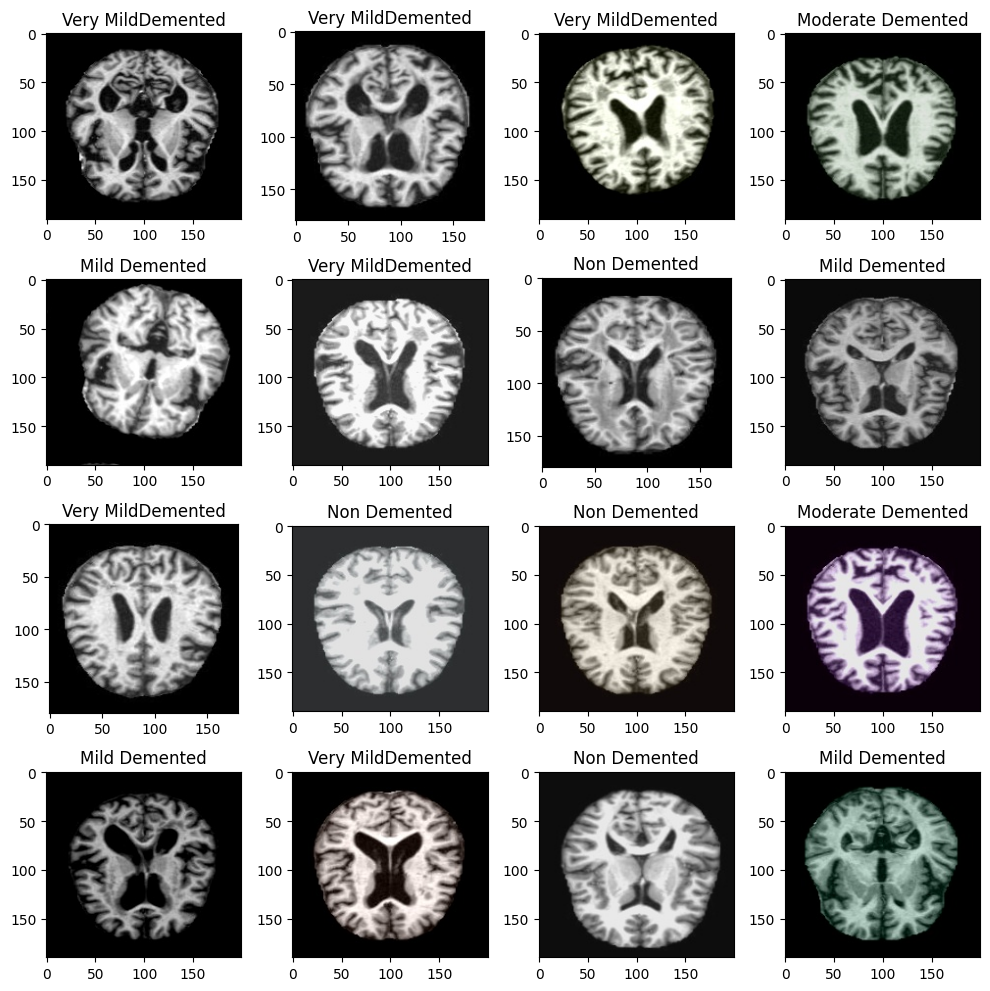

In [10]:
random_index = np.random.randint(0, len(df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
axes = axes.flat
for i,ax in enumerate(axes):
    ax.imshow(plt.imread(df.filepaths[random_index[i]]))
    ax.set_title(df.labels[random_index[i]])
plt.tight_layout()
plt.show()

In [11]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
df

,filepaths,labels
0,/kaggle/input/augmented-alzheimer-mri-dataset/...,Non Demented
1,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented
2,/kaggle/input/augmented-alzheimer-mri-dataset/...,Non Demented
3,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented
4,/kaggle/input/augmented-alzheimer-mri-dataset/...,Moderate Demented
...,...,...
33979,/kaggle/input/augmented-alzheimer-mri-dataset/...,Non Demented
33980,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented
33981,/kaggle/input/augmented-alzheimer-mri-dataset/...,Moderate Demented
33982,/kaggle/input/augmented-alzheimer-mri-dataset/...,Mild Demented


In [13]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [29]:
# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="filepaths",
                                                    y_col="labels",
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='sparse')

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  x_col="filepaths",
                                                  y_col="labels",
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='sparse')

Found 27187 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [31]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
850/850 [==============================] - 611s 704ms/step - loss: 1.0489 - accuracy: 0.5186 - val_loss: 0.7948 - val_accuracy: 0.6340
Epoch 2/10
850/850 [==============================] - 403s 474ms/step - loss: 0.7638 - accuracy: 0.6519 - val_loss: 0.6560 - val_accuracy: 0.7093
Epoch 3/10
850/850 [==============================] - 405s 477ms/step - loss: 0.6716 - accuracy: 0.6998 - val_loss: 0.6177 - val_accuracy: 0.7215
Epoch 4/10
850/850 [==============================] - 400s 470ms/step - loss: 0.6070 - accuracy: 0.7291 - val_loss: 0.5285 - val_accuracy: 0.7723
Epoch 5/10
850/850 [==============================] - 400s 471ms/step - loss: 0.5602 - accuracy: 0.7550 - val_loss: 0.4704 - val_accuracy: 0.7976
Epoch 6/10
850/850 [==============================] - 397s 467ms/step - loss: 0.5155 - accuracy: 0.7745 - val_loss: 0.4457 - val_accuracy: 0.8102
Epoch 7/10
850/850 [==============================] - 395s 465ms/step - loss: 0.4799 - accuracy: 0.7943 - val_loss: 0.4271 -

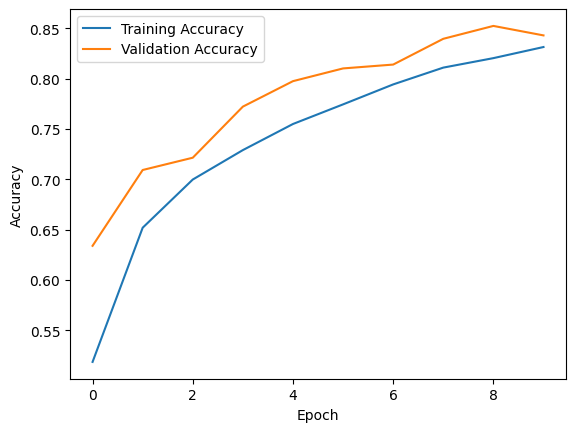

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

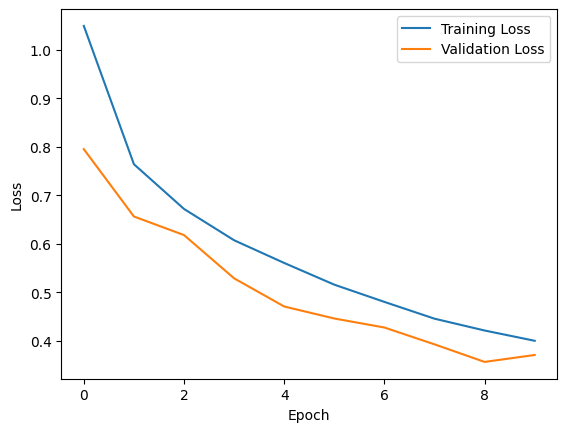

In [33]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
model.save("1stModel.h5")